In [1]:
import ee
import numpy as np
import xarray as xr
import geemap

In [2]:
# Initialize the Earth Engine Python API
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [58]:
from anomaly_processing import anomaly_processing

gee_image, landsat_collection, summer_composite = anomaly_processing(
                                                'Arkhangai',
                                                'Chuluut',
                                                'NDVI',
                                                '2023',
                                                True
                                            )

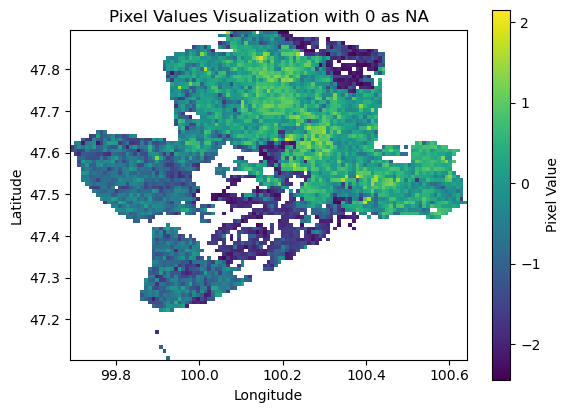

In [81]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Sample data (replace this with your actual Google Earth Engine Image data)
# Get the latlon image
latlon = ee.Image.pixelLonLat().addBands(gee_image)

# Get the coordinates and pixel values using latlon image
latlon_data = latlon.unmask().reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=gee_image.geometry(),
    maxPixels=1e13,
    scale=1000
)

# Extract the pixel values, latitudes, and longitudes from the latlon_data dictionary
pixel_values = np.array(latlon_data.get('z_score').getInfo())
lats = np.array(latlon_data.get('latitude').getInfo())
lons = np.array(latlon_data.get('longitude').getInfo())

# Get unique latitudes and longitudes
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
ncols = len(uniqueLons)
nrows = len(uniqueLats)

# Create a 2D array with NaN values to store the pixel values in a grid
arr = np.full((nrows, ncols), np.nan, dtype=np.float32)

# Calculate the linear index corresponding to each latitude and longitude pair
y_indices = np.searchsorted(uniqueLats, lats)
x_indices = np.searchsorted(uniqueLons, lons)

# Assign pixel values to the arr array using linear indexing
arr[y_indices, x_indices] = pixel_values

# Create an xarray DataArray using the grid and the pixel values numpy array
da_z_score = xr.DataArray(arr, coords=[uniqueLats, uniqueLons], dims=['latitude', 'longitude'])

# Set 0 as NA (Not a Number) for the z-score band in the DataArray
da_z_score = da_z_score.where(da_z_score != 0, np.nan)

# Plot the DataArray with 0 as NA
plt.imshow(da_z_score, cmap='viridis', extent=[uniqueLons.min(), uniqueLons.max(), uniqueLats.min(), uniqueLats.max()], origin='lower')
plt.colorbar(label='Pixel Value')  # Add a colorbar with pixel values
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pixel Values Visualization with 0 as NA')
plt.show()

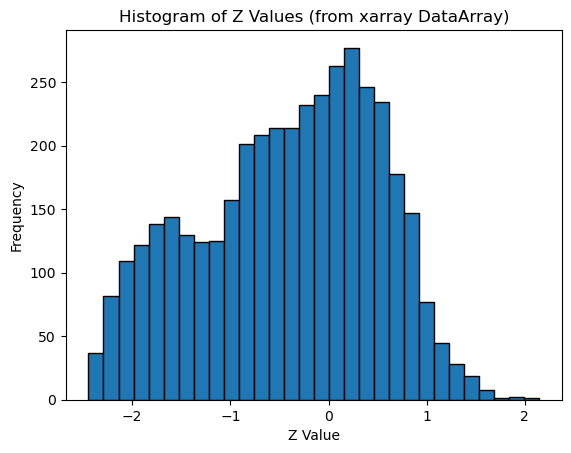

In [83]:
# Plot the histogram
da_z_score.plot.hist(bins=30, edgecolor='black')
plt.xlabel('Z Value')
plt.ylabel('Frequency')
plt.title('Histogram of Z Values (from xarray DataArray)')
plt.show()